<a href="https://colab.research.google.com/github/ryanalumkal/DE1-SoC-Voice-Controlled-Rover/blob/main/ECE243_SpeechCommands_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Source: https://www.tensorflow.org/tutorials/audio/simple_audio

In [4]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [8]:
DATASET_PATH = '/home/alumkalryan/De1-Soc-Voice-Controlled-Rover/DE1-SoC-Voice-Controlled-Rover/data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [9]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != "no") & (commands != "yes")] #UPDATE LIST OF COMMANDS
print('Commands:', commands)

Commands: ['go' 'right' 'down' 'left' 'stop' 'up']


In [10]:
for root, dirs, files in os.walk(data_dir):
  print(dirs)

['go', 'right', 'down', 'no', 'left', 'stop', 'up', 'yes']
[]
[]
[]
[]
[]
[]
[]
[]


In [11]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    labels = "inferred",
    class_names = ['up', 'right', 'stop', 'left', 'go', 'down'],
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000, #2 seconds for DE1_SoC
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)
saved_labels = label_names

Found 6000 files belonging to 6 classes.
Using 4800 files for training.
Using 1200 files for validation.

label names: ['up' 'right' 'stop' 'left' 'go' 'down']


I0000 00:00:1742137442.938187 1232489 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-16 11:04:03.124838: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [14]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [15]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2025-03-16 11:04:32.719646: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
label_names[[1,1,3,0]]

array(['right', 'right', 'left', 'up'], dtype='<U5')

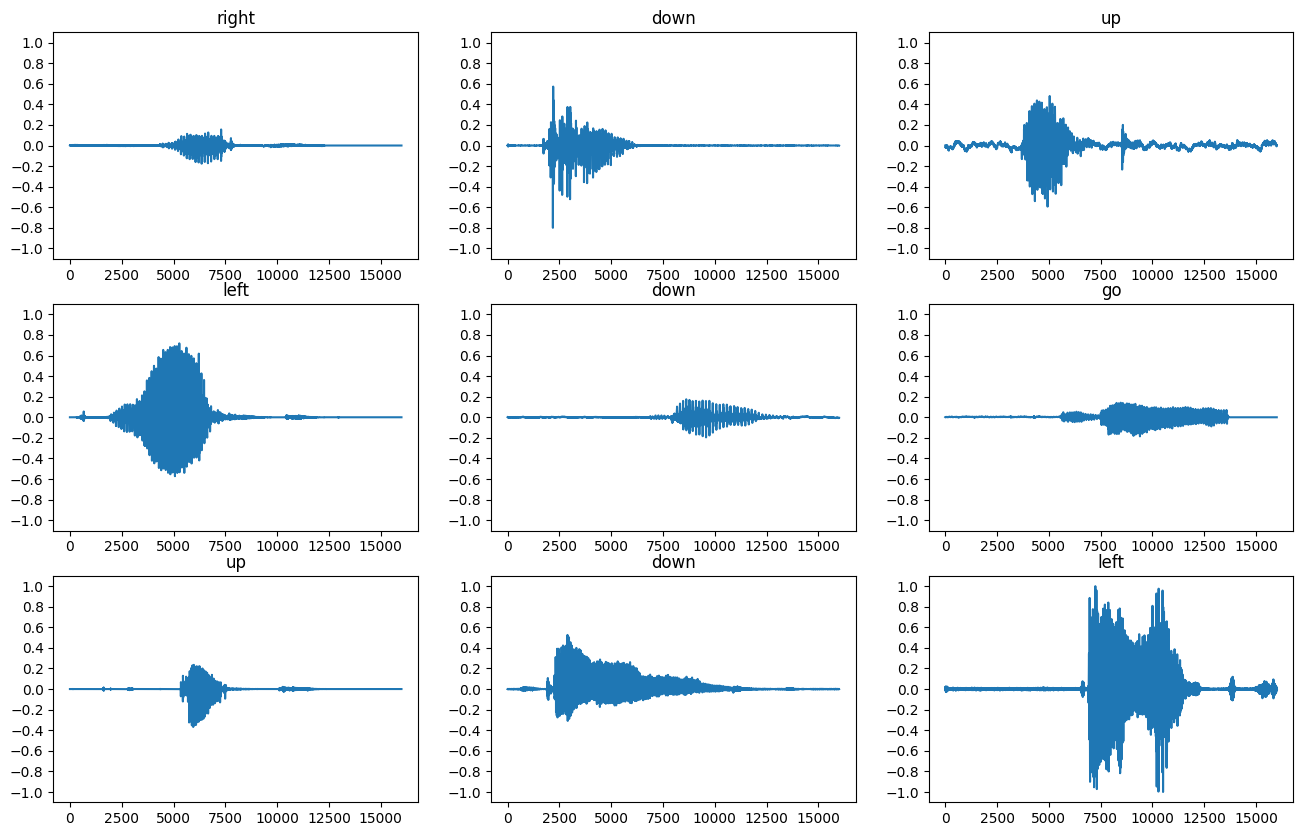

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Convert waveform to spectrograms

In [18]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [19]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

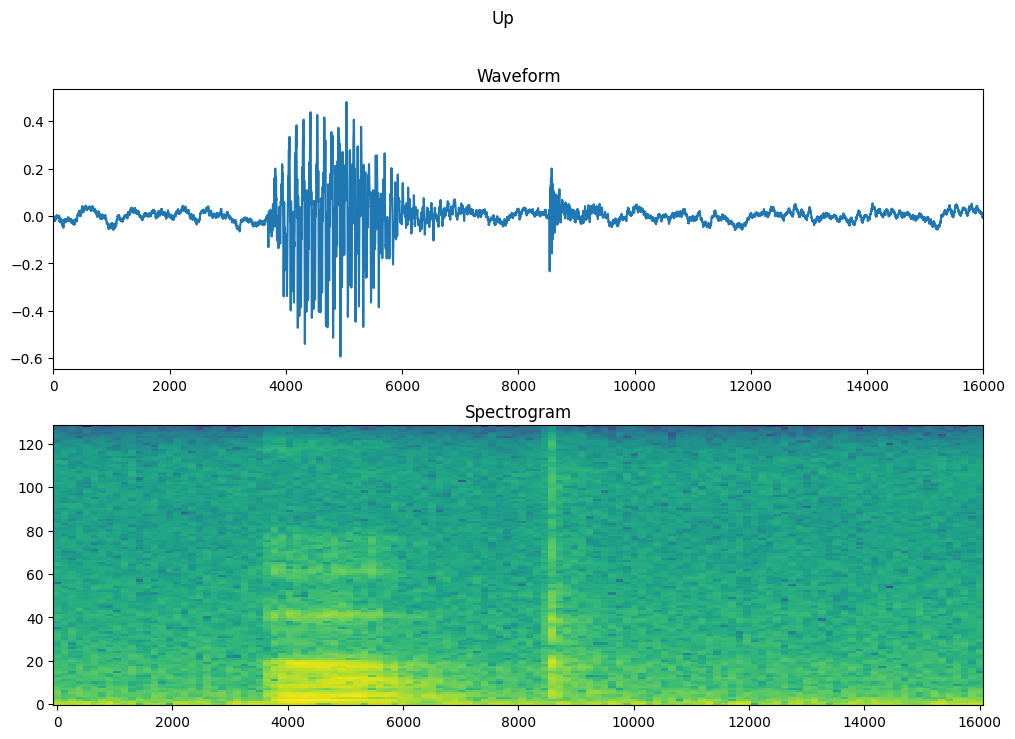

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [23]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [25]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

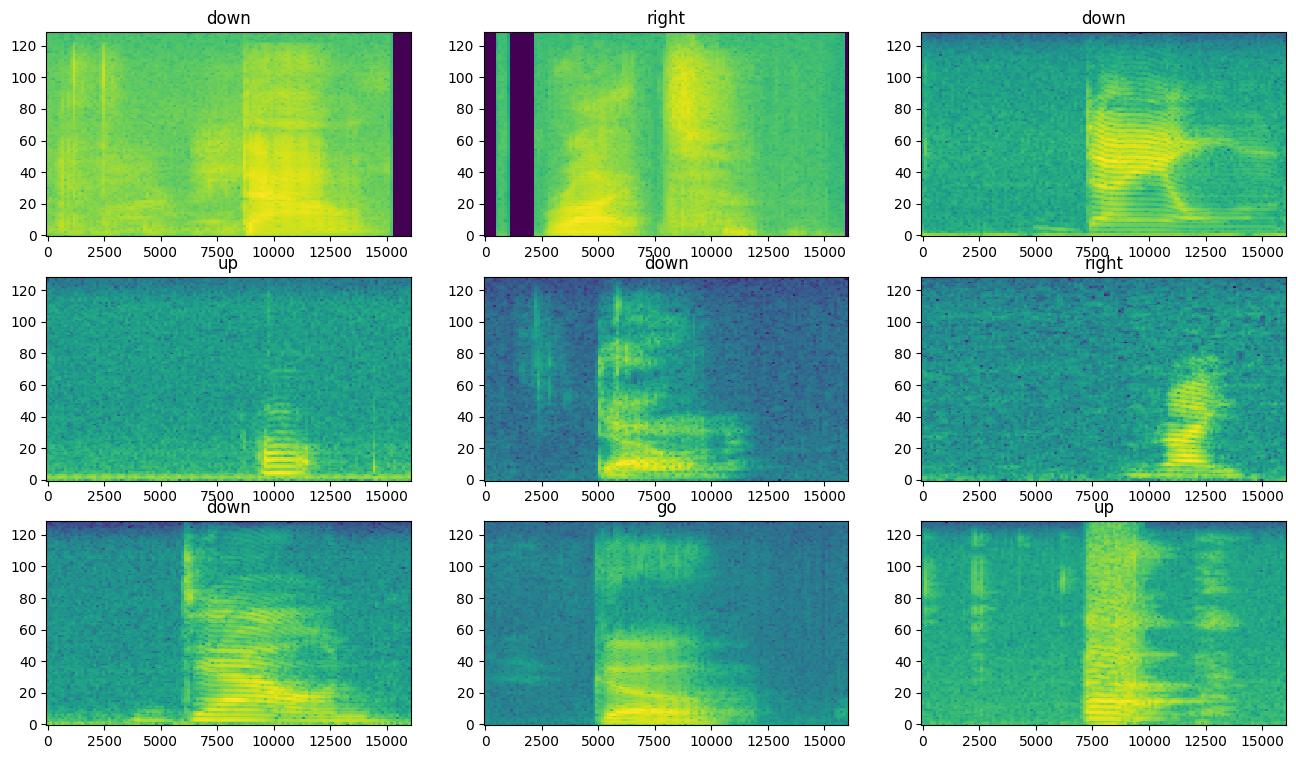

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build + Train Model

In [27]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [28]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2025-03-16 11:05:00.281408: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,113 (621.54 KB)

 Trainable params: 159,110 (621.52 KB)

 Non-trainable params: 3 (16.00 B)

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
EPOCHS = 25
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2100 - loss: 1.7916 - val_accuracy: 0.5052 - val_loss: 1.4346
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4794 - loss: 1.4088 - val_accuracy: 0.6562 - val_loss: 1.0342
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6082 - loss: 1.0635 - val_accuracy: 0.7378 - val_loss: 0.7996
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6925 - loss: 0.8635 - val_accuracy: 0.7934 - val_loss: 0.6656
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7514 - loss: 0.6901 - val_accuracy: 0.8351 - val_loss: 0.5730
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7866 - loss: 0.6462 - val_accuracy: 0.8403 - val_loss: 0.5447
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8004 - loss: 0.5728 - val_accuracy: 0.8472 - val_loss: 0.4465
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8355 - loss: 0.4909 - val_accuracy: 0.8559 - v

Text(0, 0.5, 'Accuracy [%]')

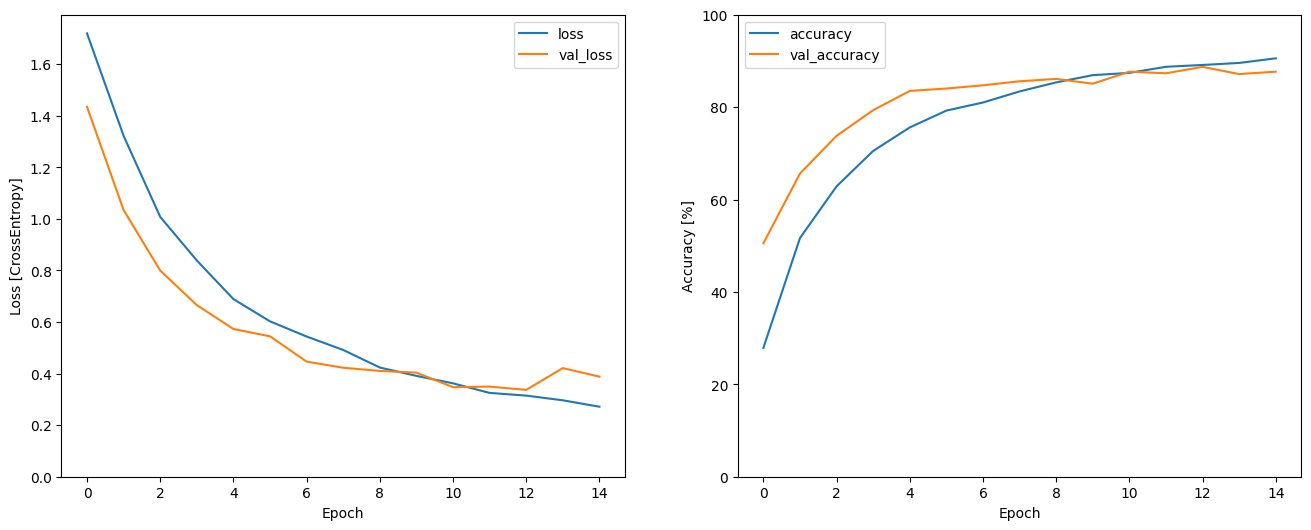

In [31]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Evaluate

In [32]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9081 - loss: 0.2902


{'accuracy': 0.9022436141967773, 'loss': 0.2896602153778076}

In [33]:
y_pred = model.predict(test_spectrogram_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [34]:
y_pred = tf.argmax(y_pred, axis=1)

In [35]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

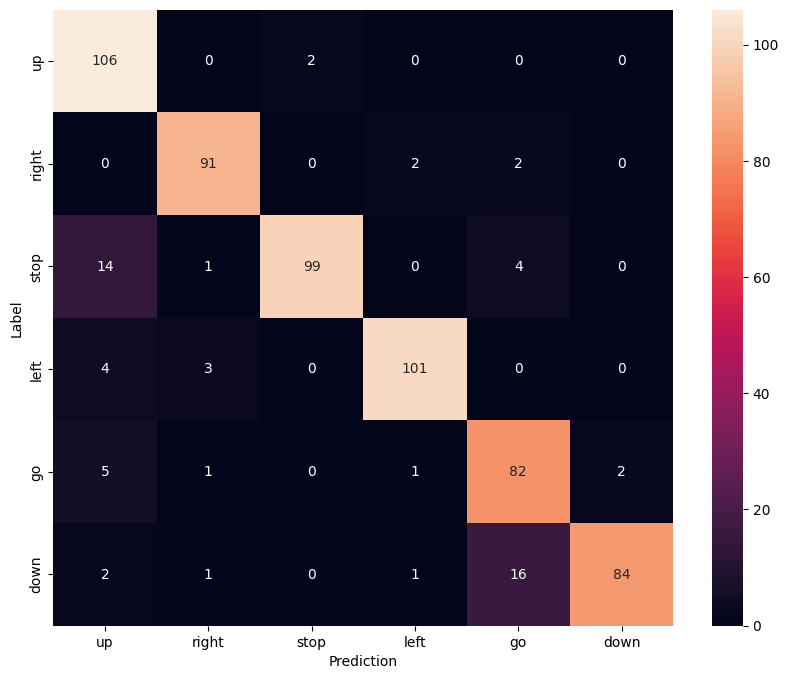

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Testing on our voices

In [38]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 18.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.2/446.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 KB 24.6 MB/s eta 0:00:00


In [39]:
from scipy.io import wavfile
import librosa
import soundfile as sf

path = '/content/drive/MyDrive/Colab Notebooks/audio recordings/right/record (21).wav'

audio, sample_rate = librosa.load(path, sr=16000)
sf.write(path, audio, 16000)

sample_rate, samples = wavfile.read(path)

print(sample_rate)
print(samples.shape)

/tmp/ipykernel_1232489/3685999875.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(path, sr=16000)
/home/alumkalryan/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/audio recordings/right/record (21).wav'

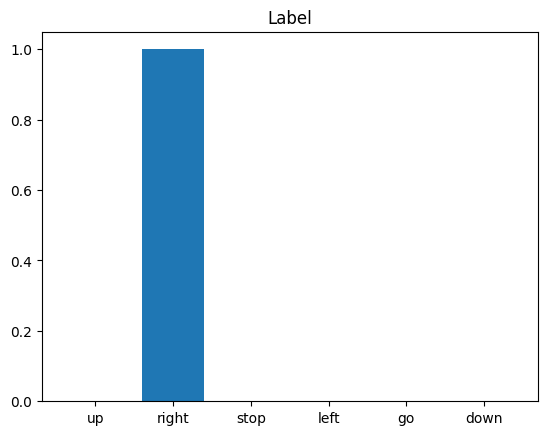

In [ ]:
x = path
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names #have a feeling the order is completely wrong
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Label')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Model Info

In [40]:
layers = model.layers
layers

[<Resizing name=resizing, built=True>,
 <Normalization name=normalization, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>]

# Export Model

In [41]:
weights = model.get_weights()

for weight,layer in zip(weights, layers):
  print(f'{layer}: {weight}')

<Resizing name=resizing, built=True>: [0.12297514]
<Normalization name=normalization, built=True>: [0.5752712]
<Conv2D name=conv2d, built=True>: 0
<MaxPooling2D name=max_pooling2d, built=True>: [[[[ 0.16074683 -0.08620612 -0.01026175  0.16897847  0.06018626
    -0.11277093 -0.13758904  0.13562311  0.05386749  0.16106392
    -0.15927744  0.1822551   0.16822635  0.01801159  0.06948163
    -0.18540195  0.06862101  0.10008342  0.04011764  0.12027185
     0.13442911  0.02984137  0.17405054  0.19207025 -0.24900843
    -0.01332679 -0.03678884 -0.34360433  0.00829834 -0.0241448
    -0.06081955 -0.04512183]]

  [[ 0.01914514 -0.04031572  0.05262056  0.13848354  0.14418733
     0.02846995  0.1052122   0.10871625  0.05634914  0.20119916
    -0.19309235  0.0173038   0.04852653  0.09371439 -0.07945602
    -0.13190867  0.00717364  0.12039535 -0.22894174  0.07859614
    -0.07235681  0.10933938 -0.0404713   0.09279199 -0.02437476
    -0.13893415  0.06056872 -0.36474198  0.21640797  0.17488642
    -0.0

In [42]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

# To C

In [ ]:
export = ExportModel(model)

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")

In [ ]:
print(imported.signatures)


_SignatureMap({})


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizers = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpyp47y55i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139899900218640: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  139899900215760: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  139899900216144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899900219024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897623376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897624720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897625680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897624528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139899897626064: TensorSpec(shape=(), dtype=tf.resource, name=None